In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import statsmodels.tsa.api as tsa

#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

In [19]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [46]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [55]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):

### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [56]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

# Part 1

In [4]:
# Load the provided csv.
covid_df = pd.read_csv('/content/drive/MyDrive/datasets/us-covid-confirmed.csv')

In [ ]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,24012023,25012023,26012023,27012023,28012023,29012023,30012023,31012023,01022023,02022023
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19389,19471,19471,19471,19471,19471,19471,19471,19530,19530
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,68764,68983,68983,68983,68983,68983,68983,68983,69187,69187
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7258,7299,7299,7299,7299,7299,7299,7299,7339,7339
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,7889,7919,7919,7919,7919,7919,7919,7919,7967,7967
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18130,18255,18255,18255,18255,18255,18255,18255,18349,18349


In [5]:
# Prepare the data as a time series DataFrame:

# Melt the wide-form data into a long-form time series.

covid_df = pd.melt(covid_df, id_vars=[
    'UID',
    'iso2',
    'iso3',
    'code3',
    'FIPS',
    'Admin2',
    'Province_State',
    'Country_Region',
    'Lat',
    'Long_',
    'Combined_Key'
  ], var_name='Date', value_name='Confirmed')


In [ ]:
covid_df.loc[(covid_df['UID']==84001001)&(covid_df['date']==28012023)]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,date,covid_cases
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",22012020,0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",22012020,0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",22012020,0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22012020,0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",22012020,0


In [ ]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702936 entries, 0 to 3702935
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   UID             int64  
 1   iso2            object 
 2   iso3            object 
 3   code3           int64  
 4   FIPS            float64
 5   Admin2          object 
 6   Province_State  object 
 7   Country_Region  object 
 8   Lat             float64
 9   Long_           float64
 10  Combined_Key    object 
 11  date            object 
 12  covid_cases     int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 367.3+ MB


In [ ]:
covid_df.loc[(covid_df['UID']==84001001)&(covid_df['date']=='28012023')]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,date,covid_cases
3682884,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",28012023,19471


In [6]:
# Convert the Date column to a Datetime index.
# Use the format argument, format = "%d%m%Y"
covid_df['Date'] = pd.to_datetime(covid_df['Date'], format='%d%m%Y')

# Set the Date column as the index
covid_df = covid_df.set_index('Date')

In [ ]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,,,,,,,
2020-01-22,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0
2020-01-22,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0
2020-01-22,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0
2020-01-22,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0
2020-01-22,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0


In [ ]:
covid_df.index

DatetimeIndex(['2020-01-22', '2020-01-22', '2020-01-22', '2020-01-22',
               '2020-01-22', '2020-01-22', '2020-01-22', '2020-01-22',
               '2020-01-22', '2020-01-22',
               ...
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02'],
              dtype='datetime64[ns]', name='Date', length=3702936, freq=None)

In [10]:
# Filter the data:
# Keep data from the following states:
#'New York', "New Jersey", "Pennsylvania", 'Delaware', 'Rhode Island', 'Maryland', "Virginia", "North Carolina"
# Keep all data from 05/2020 to the present.

covid_filtered_df = covid_df.loc[
    covid_df['Province_State'].isin(['New York', "New Jersey", "Pennsylvania", 'Delaware', 'Rhode Island', 'Maryland', "Virginia", "North Carolina"])
].loc['2020-05':]

In [ ]:
covid_filtered_df.index

DatetimeIndex(['2020-05-01', '2020-05-01', '2020-05-01', '2020-05-01',
               '2020-05-01', '2020-05-01', '2020-05-01', '2020-05-01',
               '2020-05-01', '2020-05-01',
               ...
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02', '2023-02-02', '2023-02-02',
               '2023-02-02', '2023-02-02'],
              dtype='datetime64[ns]', name='Date', length=434448, freq=None)

In [ ]:
# Save the processed data as a .csv file in a “Data” folder inside your private repo, name the csv “Data/data-for-tableau.csv”
covid_filtered_df.to_csv('/content/drive/MyDrive/datasets/data-for-tableau.csv')

In [11]:
# Resample the cases, grouped by states, as daily frequency using sum as the aggregate function.
covid_filtered_ts = covid_filtered_df.groupby('Province_State').resample('D')['Confirmed'].sum()

In [12]:
covid_filtered_ts = covid_filtered_ts.reset_index().set_index('Date')

In [13]:
covid_filtered_ts

,Province_State,Confirmed
Date,,
2020-05-01,Delaware,4918
2020-05-02,Delaware,5038
2020-05-03,Delaware,5208
2020-05-04,Delaware,5288
2020-05-05,Delaware,5371
...,...,...
2023-01-29,Virginia,2251042
2023-01-30,Virginia,2251042
2023-01-31,Virginia,2260796


Province_State
Delaware          Axes(0.125,0.11;0.775x0.77)
Maryland          Axes(0.125,0.11;0.775x0.77)
New Jersey        Axes(0.125,0.11;0.775x0.77)
New York          Axes(0.125,0.11;0.775x0.77)
North Carolina    Axes(0.125,0.11;0.775x0.77)
Pennsylvania      Axes(0.125,0.11;0.775x0.77)
Rhode Island      Axes(0.125,0.11;0.775x0.77)
Virginia          Axes(0.125,0.11;0.775x0.77)
Name: Confirmed, dtype: object

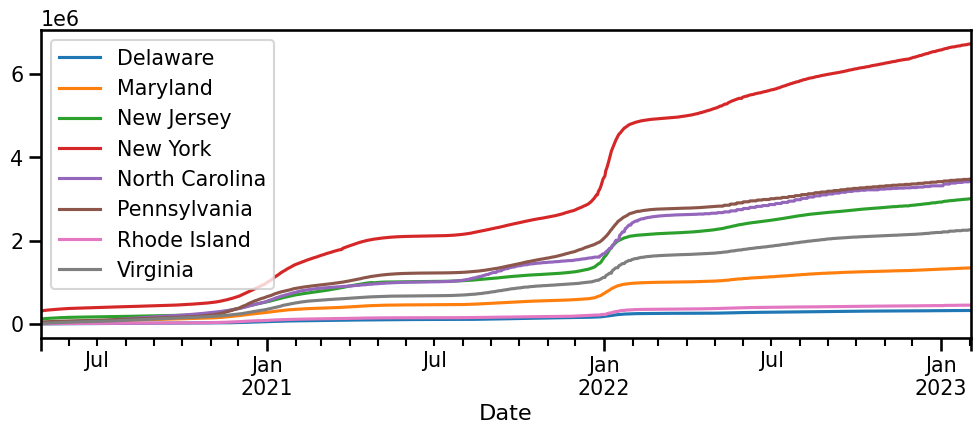

In [ ]:
# Plot a line graph with each state's Confirmed cases as a separate line.
covid_filtered_ts.groupby('Province_State')['Confirmed'].plot(legend=True)

# Part 2

In [14]:
# Filter the data and transform the data to obtain a time series of the cases count by week.
# New York
# Resample to weekly counts using .last() to get the cumulative count on the last day of the week
# After resampling, filter to keep dates from 05/2020 through 01/2023.
covid_filtered_ts = covid_filtered_ts.loc[covid_filtered_ts['Province_State']=='New York'].resample('W')
covid_filtered_ts

In [15]:
covid_filtered_ts = covid_filtered_ts.last()

In [16]:
covid_filtered_ts = covid_filtered_ts['Confirmed']

In [17]:
# Check for and address null values.
covid_filtered_ts.isna().sum()

0

In [27]:
# Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
sd = tsa.seasonal_decompose(covid_filtered_ts)

In [18]:
covid_filtered_ts

Date
2020-05-03     320685
2020-05-10     339202
2020-05-17     353002
2020-05-24     364697
2020-05-31     373682
               ...   
2023-01-08    6615741
2023-01-15    6649934
2023-01-22    6675480
2023-01-29    6702694
2023-02-05    6721124
Freq: W-SUN, Name: Confirmed, Length: 145, dtype: int64

AttributeError: 'Figure' object has no attribute 'tight_layoutht_layout'

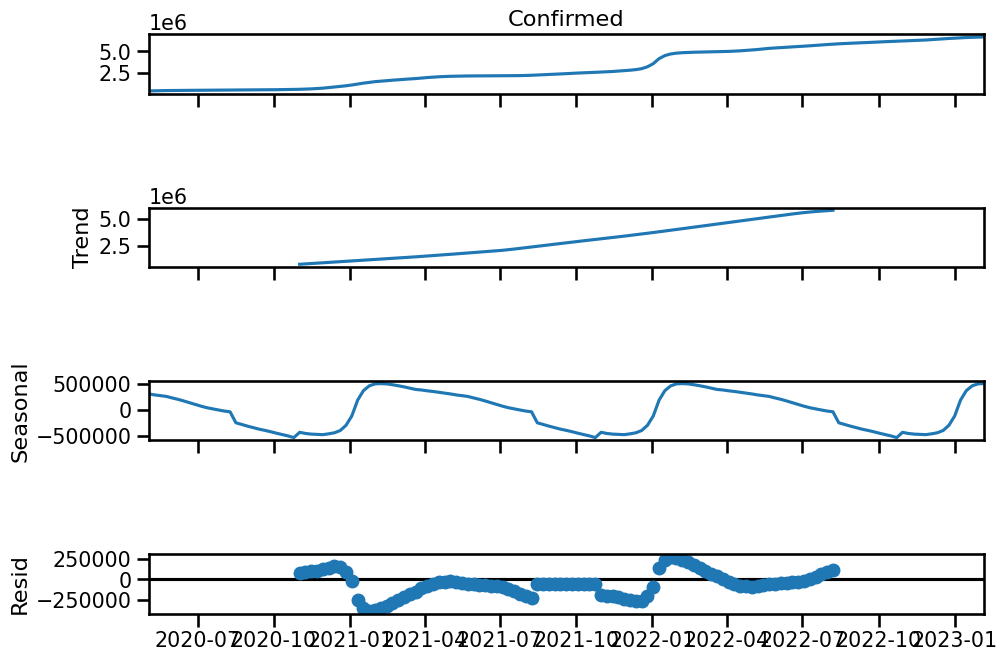

In [29]:
fig = sd.plot()
fig.set_size_inches(10,8)
plt.xticks(rotation=90)

<Axes: xlabel='Date'>

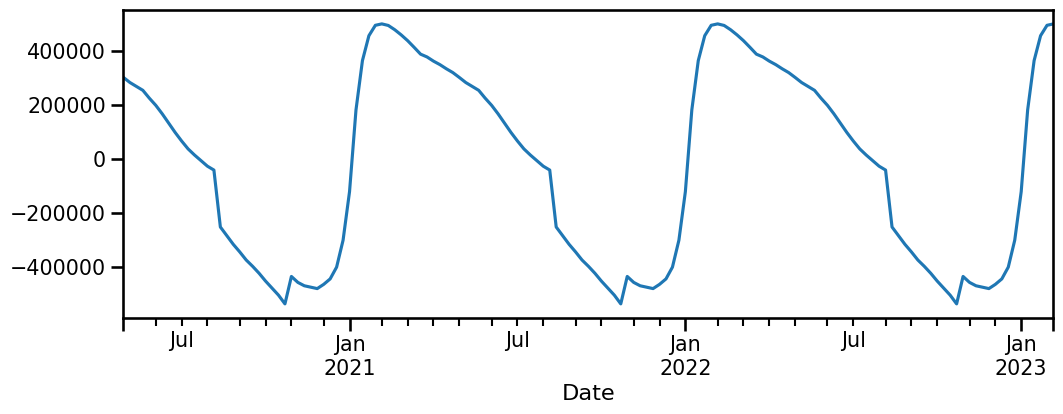

In [32]:
sd.seasonal.plot()


Use the ACF and PACF plots of stationarity data to estimate initial orders
Split the time series into training and test data (Remember we want to predict 4 weeks)
(You may get warnings when fitting models, but that is okay.)








In [20]:
# Determine if nonseasonal and/or seasonal differencing is required
get_adfuller_results(covid_filtered_ts, alpha=.05, label='adfuller')

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.042394,2,142,0.961901,0.05,False


In [21]:
covid_filtered_ts_diff = covid_filtered_ts.diff()

In [39]:
covid_filtered_ts_diff = covid_filtered_ts_diff.loc['2020-05-10 ':]

In [24]:
get_adfuller_results(covid_filtered_ts_diff.loc['2020-05-10 ':], alpha=.05, label='adfuller')

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.002499,1,142,0.000022,0.05,True


Date
2020-05-03        NaN
2020-05-10    18517.0
2020-05-17    13800.0
2020-05-24    11695.0
2020-05-31     8985.0
               ...   
2023-01-08    39474.0
2023-01-15    34193.0
2023-01-22    25546.0
2023-01-29    27214.0
2023-02-05    18430.0
Freq: W-SUN, Name: Confirmed, Length: 145, dtype: float64

In [25]:
ndiffs(covid_filtered_ts) # -> d=1

1

In [33]:
# determine m
covid_filtered_ts.loc['2022'].shape

(52,)

In [47]:
nsdiffs(covid_filtered_ts_diff, m=52) # -> D=0

0

In [ ]:
# Use the ACF and PACF plots of stationarity data to estimate initial orders

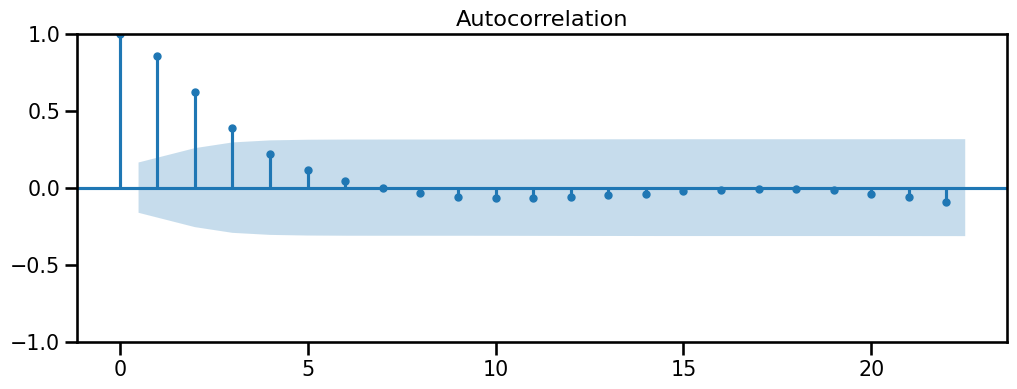

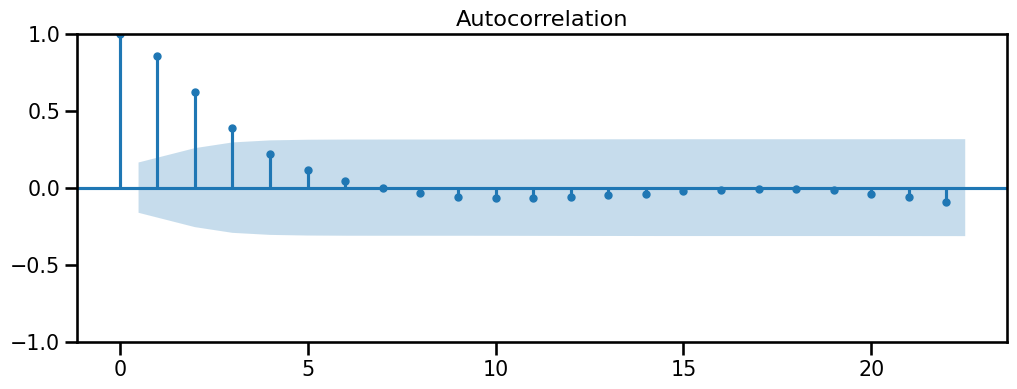

In [42]:
tsa.graphics.plot_acf(covid_filtered_ts_diff)

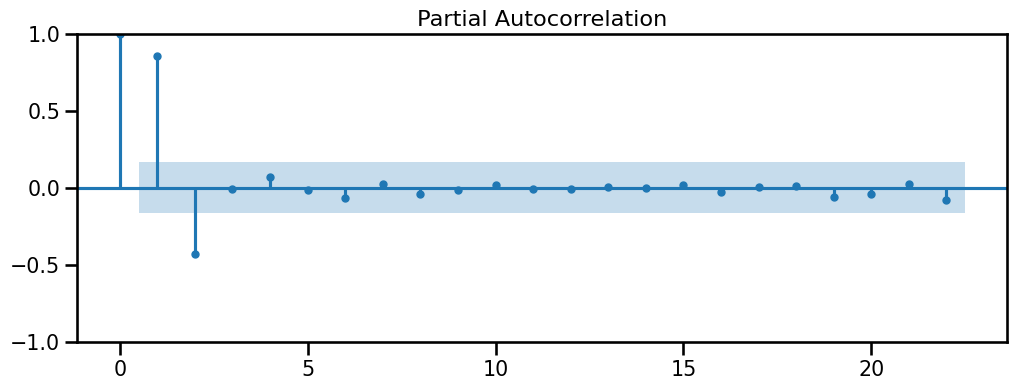

In [41]:
tsa.graphics.plot_pacf(covid_filtered_ts_diff, method='ywm');

In [ ]:
# Initial start p=2, q=0

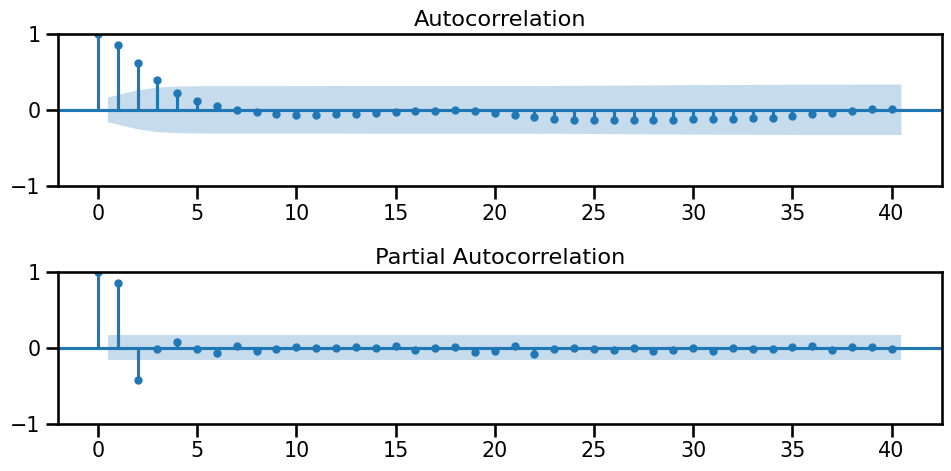

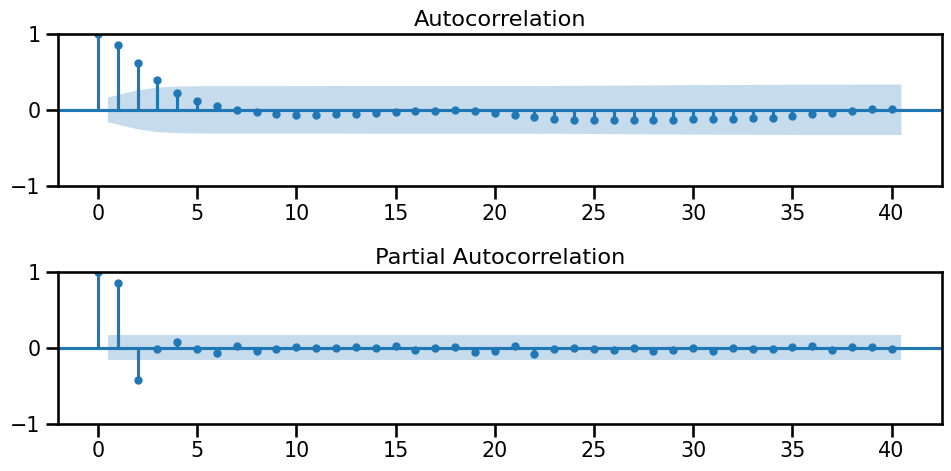

In [48]:
plot_acf_pacf(covid_filtered_ts_diff, m=52)

In [ ]:
# Initial start P=2, Q=0

In [49]:
# Split the time series into training and test data (Remember we want to predict 4 weeks)
covid_filtered_ts_train = covid_filtered_ts.iloc[:-4]
covid_filtered_ts_test = covid_filtered_ts.iloc[-4:]

In [50]:
covid_filtered_ts_test

Date
2023-01-15    6649934
2023-01-22    6675480
2023-01-29    6702694
2023-02-05    6721124
Freq: W-SUN, Name: Confirmed, dtype: int64

In [52]:
# Another way of splitting
covid_filtered_ts_train, covid_filtered_ts_test = train_test_split(covid_filtered_ts, test_size=4)
covid_filtered_ts_test

Date
2023-01-15    6649934
2023-01-22    6675480
2023-01-29    6702694
2023-02-05    6721124
Freq: W-SUN, Name: Confirmed, dtype: int64

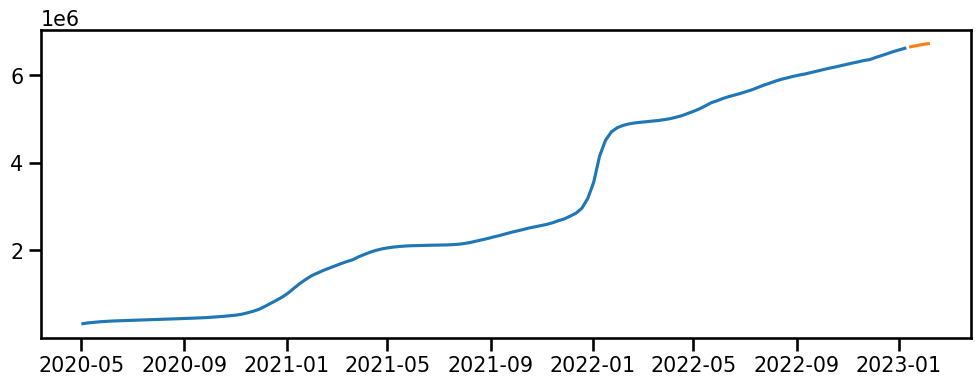

In [51]:
plt.plot(covid_filtered_ts_train)
plt.plot(covid_filtered_ts_test)

In [ ]:
#Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
# Obtain the model summary
# Obtain the diagnostic plots
# Make forecasts with your model.
# Plot the forecasts versus the test data
# Obtain metrics for evaluation

In [54]:
# Initial model

# Orders for non seasonal components
p = 2 # nonseasonal AR
d = 1 # nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 2  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 52 # Seasonal period

model_1 = tsa.ARIMA(covid_filtered_ts_train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 32,594.842
- MSE = 1,246,023,258.141
- RMSE = 35,299.055
- R^2 = -0.709
- MAPE = 0.49%


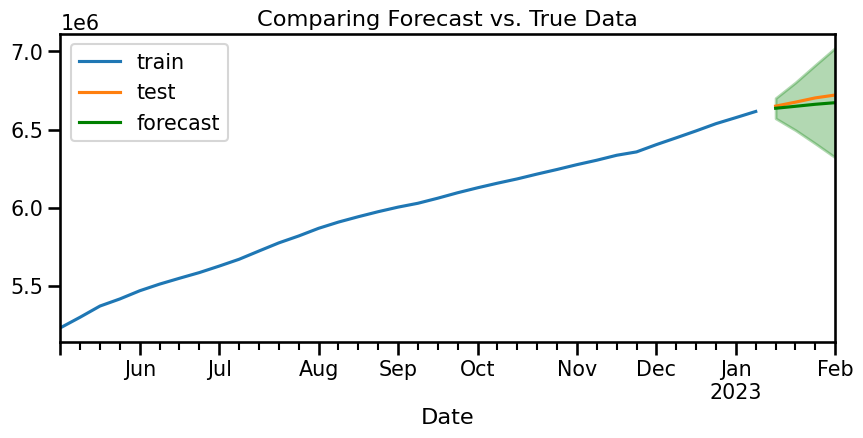

In [57]:
# Obtain summary of forecast as dataframe
forecast_df = model_1.get_forecast(len(covid_filtered_ts_test)).summary_frame()
# Plot the forecast with true values
plot_forecast(covid_filtered_ts_train, covid_filtered_ts_test, forecast_df, n_train_lags=36)
# Obtain metrics
regression_metrics_ts(covid_filtered_ts_test, forecast_df['mean'])

In [ ]:
# Tune with pmdarima's auto_arima
# Fit a model on training data with the best parameters from auto_arima
# Obtain the model summary
# Obtain the diagnostic plots
# Obtain metrics for evaluation
# Make forecasts with the auto_arima model
# Plot the forecasts versus the test data

In [58]:
auto_model = pm.auto_arima(
    covid_filtered_ts_train,
    seasonal=True,
    m=52,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=3378.585, Time=4.51 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3519.340, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3385.803, Time=2.41 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3431.915, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3567.399, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=3377.377, Time=2.38 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=3376.235, Time=0.15 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=3377.182, Time=2.95 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=3376.493, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=3375.570, Time=0.10 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept   : AIC=3376.490, Time=2.18 sec
 ARIMA(2,1,1)(0,0,1)[52] intercept   : AIC=3376.660, Time=1.85 sec
 ARIMA(2,1,1)(1,0,1)[52] intercept   : AIC=3378.408, Time=5.73 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=3377.989, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0

In [59]:
model_2 = tsa.ARIMA(covid_filtered_ts_train, order=(2,1,0), seasonal_order=(0,0,0, m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,638.895
- MSE = 181,895,915.112
- RMSE = 13,486.879
- R^2 = 0.751
- MAPE = 0.16%


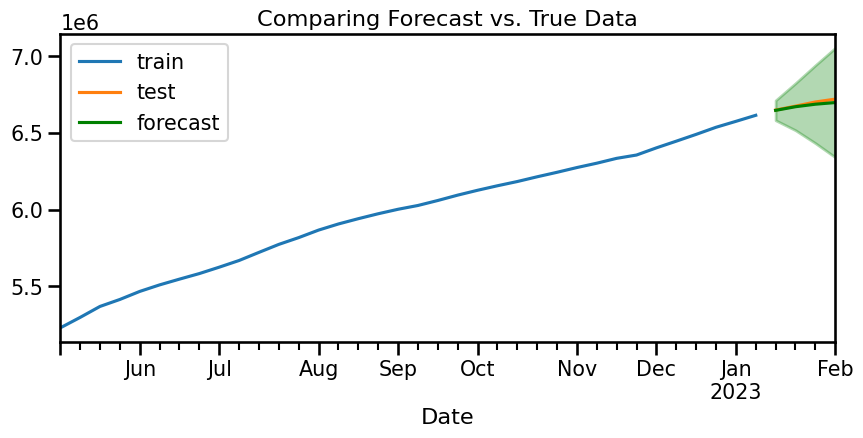

In [60]:
# Obtain summary of forecast as dataframe
forecast_df = model_2.get_forecast(len(covid_filtered_ts_test)).summary_frame()
# Plot the forecast with true values
plot_forecast(covid_filtered_ts_train, covid_filtered_ts_test, forecast_df, n_train_lags=36)
# Obtain metrics
regression_metrics_ts(covid_filtered_ts_test, forecast_df['mean'])

In [61]:
model_3 = tsa.ARIMA(covid_filtered_ts_train, order=(2,1,0)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,638.895
- MSE = 181,895,915.112
- RMSE = 13,486.879
- R^2 = 0.751
- MAPE = 0.16%


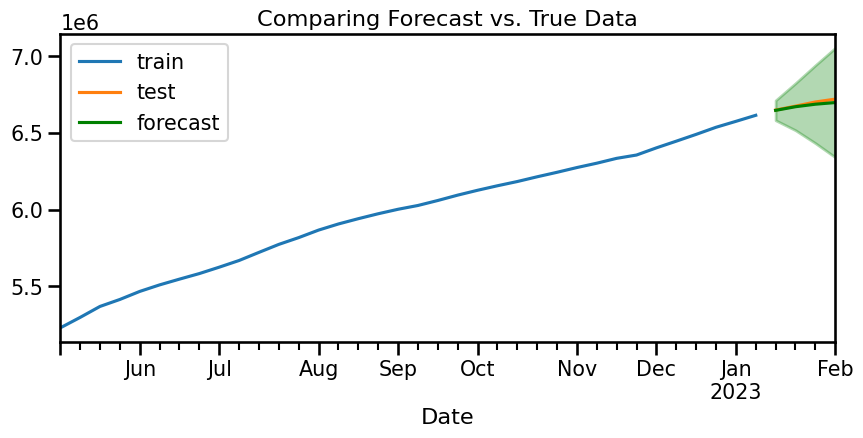

In [62]:
# Obtain summary of forecast as dataframe
forecast_df = model_3.get_forecast(len(covid_filtered_ts_test)).summary_frame()
# Plot the forecast with true values
plot_forecast(covid_filtered_ts_train, covid_filtered_ts_test, forecast_df, n_train_lags=36)
# Obtain metrics
regression_metrics_ts(covid_filtered_ts_test, forecast_df['mean'])

In [ ]:
# Make true future forecasts using the entire dataset (for dates beyond the entire ts).
# Plot the forecast along with the original ts
# Briefly summarize the forecast, including:
# Cumulative cases predicted in the final week of the forecast
# The percent change in cumulative cases over the 4-week forecast

ValueError: Found input variables with inconsistent numbers of samples: [4, 52]

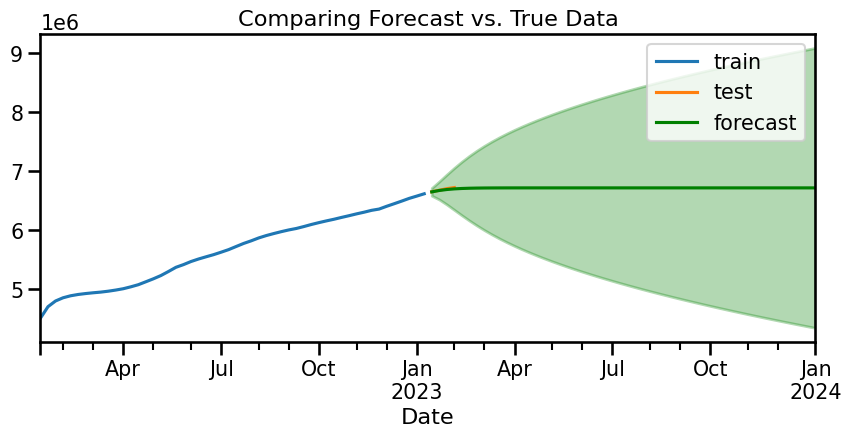

In [63]:
forecast_df = model_3.get_forecast(52).summary_frame()
# Plot the forecast with true values
plot_forecast(covid_filtered_ts_train, covid_filtered_ts_test, forecast_df, n_train_lags=52)
# Obtain metrics
regression_metrics_ts(covid_filtered_ts_test, forecast_df['mean'])

<Axes: >

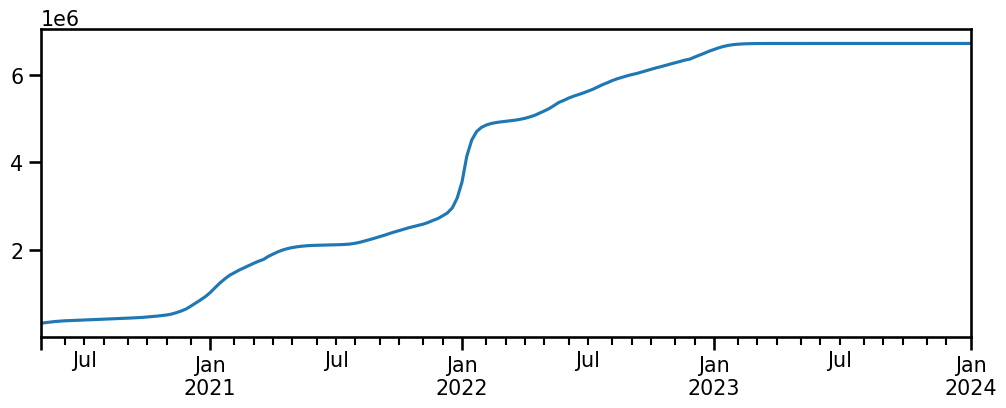

In [69]:
pd.concat([covid_filtered_ts_train, forecast_df['mean']]).plot()